# RP3xFlow Ensemble

#### Status

- Implemented Part 1 with example UCITS ETFs

## Introduction

Inspired by the fine folks at https://robotwealth.com/

Long-only volatility targeted ensemble, including:

- Risk premia harvesting strategy
- Turn-of-month flow effects strategy: bond window dressing, equity vs bond rebalance, equity rebalance

Asset universe, including:

- Equity ETF e.g. $VTI
- Bond ETF e.g. $TLT
- Gold ETF e.g. $GLD

Notebook organised into 3 parts:

1. Risk premia harvetsing strategy
2. Turn-of-month flow effect strategy
3. Portfolio ensemble

## Part 1: Risk Premia Harvesting Strategy

### 1a: Define imports and strategy parameters

In [24]:
import datetime
import calendar
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

pd.options.mode.chained_assignment = None

# Map asset class to instrument
equity_ticker = 'VNRT.L'
bond_ticker = 'IBTL.L'
gold_ticker = 'SGLN.L'
universe_tickers = [equity_ticker, bond_ticker, gold_ticker]

# Map instrument to currency denomination factor e.g. GBP = 1, GBX/GBp = 0.01
equity_ticker_denom = 1
bond_ticker_denom = 0.01
gold_ticker_denom = 0.01

# Assetwise volatility targets
equity_vol_target = 0.03
bond_vol_target = 0.03
gold_vol_target = 0.03

# Assetwise re-balance threshold as % of target position sizes 
rebalance_threshold = 0.2

# Calendar days to load data for each asset class
hist_price_period_days = 5 * 365

# Day periods to use for volatility estimation
vol_forecast_period_days = 60

# Portfolio positions used to calculate NAV and order deltas
cash_value = 1000
equity_pf_qty = 2.5
bond_pf_qty = 0
gold_pf_qty = 0

### 1b: Load asset universe data

Load historic adjusted close prices for our universe for last x days.

In [25]:
# Set period to load data, noting these are calendar days not trading days
period_end = datetime.datetime.utcnow()
period_start = period_end - datetime.timedelta(days=hist_price_period_days)

# Get daily adjusted close data from Yahoo Finance for our universe
asset_df = pdr.get_data_yahoo(universe_tickers, start=period_start, end=period_end)[['Adj Close']]

# Standardize names
asset_df = asset_df.reset_index()
asset_df = asset_df.rename_axis(columns={'Attributes': 'attribute', 'Symbols': 'ticker'})
asset_df = asset_df.rename(columns={'Date': 'date', 'Adj Close': 'price'})

# Normalize prices to use the same denomination
asset_df['price', equity_ticker] = asset_df['price', equity_ticker] * equity_ticker_denom
asset_df['price', bond_ticker] = asset_df['price', bond_ticker] * bond_ticker_denom
asset_df['price', gold_ticker] = asset_df['price', gold_ticker] * gold_ticker_denom

# Save price data to local feather file
feather_prep_df = asset_df.copy()
feather_prep_df.columns = feather_prep_df.columns.map(str)
feather_prep_df.to_feather("./prices.feather")

asset_df.tail(5)


attribute       date      price                 
ticker                   VNRT.L   IBTL.L  SGLN.L
1258      2022-08-19  87.324997  3.54650  28.850
1259      2022-08-22  86.242500  3.54300  28.755
1260      2022-08-23  85.135002  3.54550  28.785
1261      2022-08-24  85.860001  3.51675  28.945
1262      2022-08-25  86.033501  3.49450  28.920

### 1c: Enrich our asset data

Calculate and visualize derived metrics such as total returns and rolling volatility.

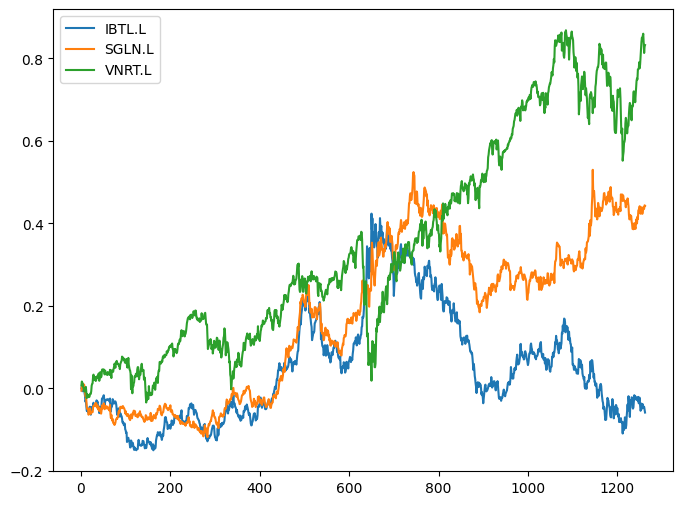

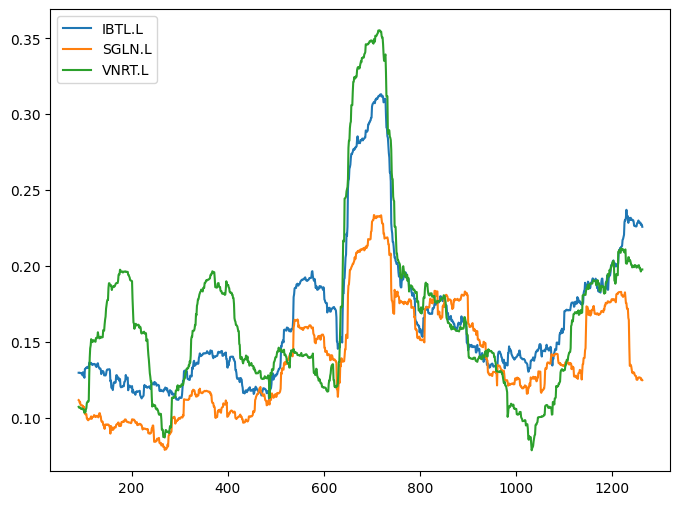

In [26]:
for ticker in universe_tickers:
    # Calculate total returns
    asset_df['return', ticker] = asset_df['price', ticker].pct_change()
    asset_df['log_return', ticker] = np.log(asset_df['price', ticker]/asset_df['price', ticker].shift(1))
    asset_df['cum_return', ticker] = (1 + asset_df['return', ticker]).cumprod() - 1
    asset_df['cum_log_return', ticker] = asset_df['log_return', ticker].cumsum()

    # Calculate rolling annual volatility for key periods
    asset_df['rolling_xd_ann_vol', ticker] = asset_df['log_return', ticker].rolling(vol_forecast_period_days).std() * math.sqrt(252)
    asset_df['rolling_30d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(30).std() * math.sqrt(252)
    asset_df['rolling_60d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(60).std() * math.sqrt(252)
    asset_df['rolling_90d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(90).std() * math.sqrt(252)

asset_df = asset_df.sort_index(axis='columns', level=1)

asset_df['cum_return'].plot(figsize=(8,6))
plt.legend(loc=2)

asset_df['rolling_90d_ann_vol'].plot(figsize=(8, 6))
plt.legend(loc=2)


### 1d: Evaluate portfolio

Compute target position sizes based on annualized volatility.

In [27]:
# Get asset data for last session as a series
latest_ds = asset_df.iloc[-2]

# Select close prices to calculate portfolio NAV
equity_price = latest_ds['price', equity_ticker]
bond_price = latest_ds['price', bond_ticker]
gold_price = latest_ds['price', gold_ticker]
portfolio_nav = cash_value + (equity_pf_qty * equity_price) + (bond_pf_qty * bond_price) + (gold_pf_qty * gold_price)

# Build dataframe of portfolio and target positions
portfolio_df = pd.DataFrame({'ticker': universe_tickers})
portfolio_df['date'] = latest_ds['date', '']
portfolio_df['price'] = [equity_price, bond_price, gold_price]
portfolio_df['ann_vol'] = [
        latest_ds['rolling_xd_ann_vol', equity_ticker],
        latest_ds['rolling_xd_ann_vol', bond_ticker],
        latest_ds['rolling_xd_ann_vol', gold_ticker]]
portfolio_df['vol_target'] = [equity_vol_target, bond_vol_target, gold_vol_target]
portfolio_df['portfolio_qty'] = [equity_pf_qty, bond_pf_qty, gold_pf_qty]
portfolio_df['target_qty'] = (portfolio_df['vol_target'] / portfolio_df['ann_vol']) * (portfolio_nav / portfolio_df['price'])
portfolio_df['delta_qty'] = (portfolio_df['target_qty'] - portfolio_df['portfolio_qty'])
portfolio_df['delta_pct'] = (portfolio_df['delta_qty'].abs() / portfolio_df['portfolio_qty'])

# Based on the assetwise rebalance param indicate if trade should be executed
portfolio_df['do_trade'] = portfolio_df['delta_pct'].apply(lambda x: True if (x >= rebalance_threshold) or math.isinf(x) else False)

portfolio_df

,ticker,date,price,ann_vol,vol_target,portfolio_qty,target_qty,delta_qty,delta_pct,do_trade
0,VNRT.L,2022-08-24,85.860001,0.191465,0.03,2.5,2.216630,-0.283370,0.113348,False
1,IBTL.L,2022-08-24,3.516750,0.223889,0.03,0.0,46.280549,46.280549,inf,True
2,SGLN.L,2022-08-24,28.945000,0.120741,0.03,0.0,10.426632,10.426632,inf,True


## Part 2: Turn-of-Month Flow Effects Strategy

This strategy consists of 3 sub-strategies that are combined into an ensemble with a shared volatility target.

In part 3, we then combine the flow effects ensemble with the risk premia harvesting strategy from part 1 to create a mega-ensemble that determines the final target positions of our portfolio.

### 2a: Strategy parameters

In addition to those defined in Part 1 we define specific params for this strategy.

In [28]:
# Volatility contribution from this specfific strategy
flow_effects_vol_target = 0.03

# Trading venue for the asset universe
exchange_label = 'LSE'

# Start of month trading day 
som_trading_day = 5

# End of month trading day
eom_trading_day = 15

### 2b: Window dressing

Purpose is to determine if we should be long or short bonds based on current month day.

In [51]:
# Default position is flat (no trade)
wd_position = 0

# Define start and end dates for current calendar month
now = datetime.datetime.utcnow()
start_range = datetime.date(year=now.year, month=now.month, day=1)
eom_day = calendar.monthrange(year=now.year, month=now.month)[1]
end_range = datetime.date(year=now.year, month=now.month, day=eom_day)

# Load trading venue calendar for current month
cal = mcal.get_calendar(exchange_label)
schedule = cal.schedule(start_date=start_range, end_date=end_range)
eom_date = schedule.iloc[-1]['market_close']
eom_minus_one_date = schedule.iloc[-2]['market_close']

# Evaluate trade direction based on current date
# Short when today is last (or last -1) trading day of month OR today is before start of month trading day param 
# Long when today is equal to or later than start of month trading day param
if now == eom_date or now == eom_minus_one_date or now.day < som_trading_day:
    wd_position = -1
elif now.day >= som_trading_day:
    wd_position = 1 

wd_position


1